In [1]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("Anime Recommendation System EDA") \
    .getOrCreate()
spark 

# Data paths
anime_data_path = "/Users/kaushik/Desktop/Data/anime-dataset-2023_new.csv"
user_details_path = "/Users/kaushik/Desktop/Data/users-details-2023_new.csv"
user_scores_path = "/Users/kaushik/Desktop/Data/users-score-2023_new.csv"
# Read the datasets
anime_df = spark.read.format("csv").option("header", "true").option("inferSchema", "true").option("escape", '"').load(anime_data_path)
users_df = spark.read.format("csv").option("header", "true").option("inferSchema", "true").option("escape", '"').load(user_details_path)
scores_df = spark.read.format("csv").option("header", "true").option("inferSchema", "true").option("escape", '"').load(user_scores_path)

anime_f_df = spark.read.csv("/Users/kaushik/Desktop/Data/anime-filtered_new.csv", header=True, inferSchema=True)

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/05/06 15:46:18 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [2]:
spark

In [3]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when, regexp_replace, lower, split, explode, year


# Handle missing values
anime_df = anime_df.dropna(how='any', subset=['Score', 'Genres', 'Type'])  # Dropping rows with missing crucial information
users_df = users_df.fillna({'Gender': 'Unknown', 'Mean Score': 0})  # Filling missing Gender with 'Unknown' and Mean Score with 0
scores_df = scores_df.na.drop(subset=["rating"])  # Drop rows where the rating is null

# Remove duplicates
anime_df = anime_df.dropDuplicates(['anime_id'])
users_df = users_df.dropDuplicates(['Mal ID'])
scores_df = scores_df.dropDuplicates(['user_id', 'anime_id'])

# Data type corrections
anime_df = anime_df.withColumn("Episodes", col("Episodes").cast("integer"))
scores_df = scores_df.withColumn("rating", col("rating").cast("float"))

# Cleaning textual data: removing unwanted characters from names and synopsis
anime_df = anime_df.withColumn("Name", regexp_replace("Name", "[^a-zA-Z0-9 ]", ""))
anime_df = anime_df.withColumn("English name", regexp_replace("English name", "[^a-zA-Z0-9 ]", ""))

# Normalize text fields
anime_df = anime_df.withColumn("Genres", lower(col("Genres")))
users_df = users_df.withColumn("Username", lower(col("Username")))


In [4]:
from pyspark.sql.functions import split, explode

# Expand genres into array and then explode it for easier analysis per genre
anime_df = anime_df.withColumn("Genres", explode(split("Genres", ", ")))

# Convert 'Aired' to year for trend analysis (assuming 'Aired' is in a recognizable date format)
anime_df = anime_df.withColumn("Year", year("Aired"))

# If exact dates aren't available, split by seasons if data like 'Spring 2021' is used
anime_df = anime_df.withColumn("Premiere Season", split(col("Premiered"), " ").getItem(0))
anime_df = anime_df.withColumn("Premiere Year", split(col("Premiered"), " ").getItem(1))


In [5]:
anime_df.printSchema()
anime_df.describe().show()
users_df.describe().show()
scores_df.describe().show()



root
 |-- _c0: string (nullable = true)
 |-- anime_id: string (nullable = true)
 |-- Name: string (nullable = true)
 |-- English name: string (nullable = true)
 |-- Other name: string (nullable = true)
 |-- Score: string (nullable = true)
 |-- Genres: string (nullable = false)
 |-- Synopsis: string (nullable = true)
 |-- Type: string (nullable = true)
 |-- Episodes: integer (nullable = true)
 |-- Aired: string (nullable = true)
 |-- Premiered: string (nullable = true)
 |-- Status: string (nullable = true)
 |-- Producers: string (nullable = true)
 |-- Licensors: string (nullable = true)
 |-- Studios: string (nullable = true)
 |-- Source: string (nullable = true)
 |-- Duration: string (nullable = true)
 |-- Rating: string (nullable = true)
 |-- Rank: string (nullable = true)
 |-- Popularity: integer (nullable = true)
 |-- Favorites: integer (nullable = true)
 |-- Scored By: string (nullable = true)
 |-- Members: integer (nullable = true)
 |-- Image URL: string (nullable = true)
 |-- Year

24/05/06 15:46:36 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.
24/05/06 15:46:37 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , anime_id, Name, English name, Other name, Score, Genres, Synopsis, Type, Episodes, Aired, Premiered, Status, Producers, Licensors, Studios, Source, Duration, Rating, Rank, Popularity, Favorites, Scored By, Members, Image URL
 Schema: _c0, anime_id, Name, English name, Other name, Score, Genres, Synopsis, Type, Episodes, Aired, Premiered, Status, Producers, Licensors, Studios, Source, Duration, Rating, Rank, Popularity, Favorites, Scored By, Members, Image URL
Expected: _c0 but found: 
CSV file: file:///Users/kaushik/Desktop/Data/anime-dataset-2023_new.csv


+-------+--------------------+------------------+------------------+--------------------+------------------+------------------+-------+--------------------+-----+------------------+------------------+------------+------------------+-----------------+------------------+--------------------+------------------+--------------------+------------+------------------+-----------------+------------------+------------------+-----------------+--------------------+------------------+---------------+------------------+
|summary|                 _c0|          anime_id|              Name|        English name|        Other name|             Score| Genres|            Synopsis| Type|          Episodes|             Aired|   Premiered|            Status|        Producers|         Licensors|             Studios|            Source|            Duration|      Rating|              Rank|       Popularity|         Favorites|         Scored By|          Members|           Image URL|              Year|Premiere Sea

24/05/06 15:46:47 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , Mal ID, Username, Gender, Location, Days Watched, Mean Score, Watching, Completed, On Hold, Dropped, Plan to Watch, Total Entries, Rewatched, Episodes Watched
 Schema: _c0, Mal ID, Username, Gender, Location, Days Watched, Mean Score, Watching, Completed, On Hold, Dropped, Plan to Watch, Total Entries, Rewatched, Episodes Watched
Expected: _c0 but found: 
CSV file: file:///Users/kaushik/Desktop/Data/users-details-2023_new.csv


+-------+-----------------+------------------+----------------+-------+--------------------+------------------+------------------+------------------+------------------+------------------+-----------------+------------------+------------------+------------------+------------------+
|summary|              _c0|            Mal ID|        Username| Gender|            Location|      Days Watched|        Mean Score|          Watching|         Completed|           On Hold|          Dropped|     Plan to Watch|     Total Entries|         Rewatched|  Episodes Watched|
+-------+-----------------+------------------+----------------+-------+--------------------+------------------+------------------+------------------+------------------+------------------+-----------------+------------------+------------------+------------------+------------------+
|  count|           731290|            731290|          731289| 731290|              152805|            731282|            731290|            731282|     

24/05/06 15:46:59 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , user_id, Username, anime_id, Anime Title, rating
 Schema: _c0, user_id, Username, anime_id, Anime Title, rating
Expected: _c0 but found: 
CSV file: file:///Users/kaushik/Desktop/Data/users-score-2023_new.csv


+-------+-----------------+------------------+----------+-----------------+------------------+------------------+
|summary|              _c0|           user_id|  Username|         anime_id|       Anime Title|            rating|
+-------+-----------------+------------------+----------+-----------------+------------------+------------------+
|  count|         24325191|          24325191|  24324959|         24325191|          24325191|          24325191|
|   mean|      1.2162595E7| 440384.2737923003|       NaN| 9754.68630597803|18265.327820869312| 7.622930072779285|
| stddev|7022077.930307082|366946.88529862644|       NaN|12061.96464528386|108176.16631061639|1.6615102992625483|
|    min|                0|                 1|   -------|                1|      !NVADE SHOW!|               1.0|
|    max|         24325190|           1291097|zzzzzombie|            56085|                 ◯|              10.0|
+-------+-----------------+------------------+----------+-----------------+-------------

In [6]:
# Assuming the dataframe has a column with Japanese titles
# Convert Japanese characters to ASCII or replace them
anime_df = anime_df.withColumn('Name', regexp_replace('Name', '[^\x00-\x7F]', ''))

# Continue with your analysis and plotting


In [7]:
from pyspark.sql import SparkSession

# Initialize Spark Session
spark = SparkSession.builder.appName("Top Anime").getOrCreate()

# Assume anime_df is already loaded and contains 'Score' and 'Name'
# Convert Spark DataFrame to Pandas DataFrame for plotting if not already in Pandas
anime_df = anime_df.sort(col("Score").desc())  # Sorting by Score in descending order
top_50_anime = anime_df.limit(50)  # Limit to top 50

# Show top 50 anime
top_50_anime.show()


24/05/02 20:48:10 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.
24/05/02 20:48:10 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , anime_id, Name, English name, Other name, Score, Genres, Synopsis, Type, Episodes, Aired, Premiered, Status, Producers, Licensors, Studios, Source, Duration, Rating, Rank, Popularity, Favorites, Scored By, Members, Image URL
 Schema: _c0, anime_id, Name, English name, Other name, Score, Genres, Synopsis, Type, Episodes, Aired, Premiered, Status, Producers, Licensors, Studios, Source, Duration, Rating, Rank, Popularity, Favorites, Scored By, Members, Image URL
Expected: _c0 but found: 
CSV file: file:///Users/kaushik/Desktop/Data/anime-dataset-2023_new.csv


+----+--------+--------------------+--------------------+--------------------------------------+-------+--------------------+--------------------+-------+--------+--------------------+-----------+---------------+--------------------+---------+-------+-------+-------------+--------------------+-------+----------+---------+---------+-------+--------------------+----+---------------+-------------+
| _c0|anime_id|                Name|        English name|                            Other name|  Score|              Genres|            Synopsis|   Type|Episodes|               Aired|  Premiered|         Status|           Producers|Licensors|Studios| Source|     Duration|              Rating|   Rank|Popularity|Favorites|Scored By|Members|           Image URL|Year|Premiere Season|Premiere Year|
+----+--------+--------------------+--------------------+--------------------------------------+-------+--------------------+--------------------+-------+--------+--------------------+-----------+--------

In [8]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col

# Assuming anime_df is a PySpark DataFrame and already loaded
# Initialize Spark Session
spark = SparkSession.builder.appName("Top Anime").getOrCreate()

# Sort by 'Score' in descending order and take the top 50
top_50_anime = anime_df.orderBy(col("Score").desc()).limit(50)

# Show the top 50 anime
top_50_anime.show()


24/05/02 20:48:54 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , anime_id, Name, English name, Other name, Score, Genres, Synopsis, Type, Episodes, Aired, Premiered, Status, Producers, Licensors, Studios, Source, Duration, Rating, Rank, Popularity, Favorites, Scored By, Members, Image URL
 Schema: _c0, anime_id, Name, English name, Other name, Score, Genres, Synopsis, Type, Episodes, Aired, Premiered, Status, Producers, Licensors, Studios, Source, Duration, Rating, Rank, Popularity, Favorites, Scored By, Members, Image URL
Expected: _c0 but found: 
CSV file: file:///Users/kaushik/Desktop/Data/anime-dataset-2023_new.csv


+----+--------+--------------------+--------------------+--------------------------------------+-------+--------------------+--------------------+-------+--------+--------------------+-----------+---------------+--------------------+---------+-------+-------+-------------+--------------------+-------+----------+---------+---------+-------+--------------------+----+---------------+-------------+
| _c0|anime_id|                Name|        English name|                            Other name|  Score|              Genres|            Synopsis|   Type|Episodes|               Aired|  Premiered|         Status|           Producers|Licensors|Studios| Source|     Duration|              Rating|   Rank|Popularity|Favorites|Scored By|Members|           Image URL|Year|Premiere Season|Premiere Year|
+----+--------+--------------------+--------------------+--------------------------------------+-------+--------------------+--------------------+-------+--------+--------------------+-----------+--------

Index(['Unnamed: 0', 'anime_id', 'Name', 'English name', 'Other name', 'Score',
       'Genres', 'Synopsis', 'Type', 'Episodes', 'Aired', 'Premiered',
       'Status', 'Producers', 'Licensors', 'Studios', 'Source', 'Duration',
       'Rating', 'Rank', 'Popularity', 'Favorites', 'Scored By', 'Members',
       'Image URL'],
      dtype='object')


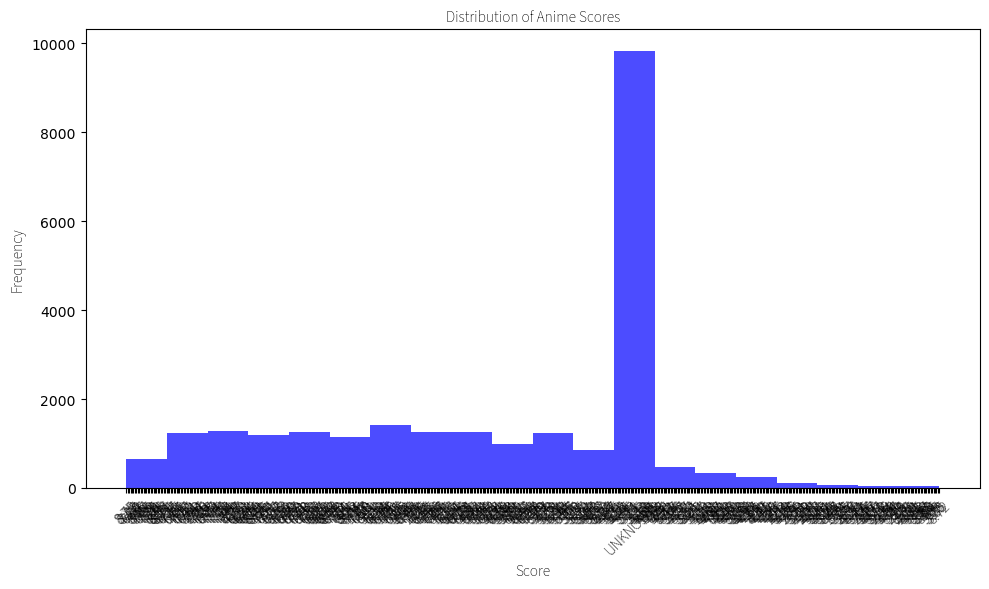

In [7]:
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
import pandas as pd

# Specify the font properties that include Japanese character support
japanese_font = FontProperties(fname='/Users/kaushik/Desktop/Data/Noto_Sans_JP/NotoSansJP-VariableFont_wght.ttf')

# Load your data into a DataFrame
score_distribution = pd.read_csv('/Users/kaushik/Desktop/Data/anime-dataset-2023_new.csv')

# Check to ensure the 'Score' column exists
print(score_distribution.columns)  # This will print the column names

# Create the histogram plot for anime scores
plt.figure(figsize=(10, 6))
plt.hist(score_distribution['Score'], bins=20, color='blue', alpha=0.7)
plt.title('Distribution of Anime Scores', fontproperties=japanese_font)
plt.xlabel('Score', fontproperties=japanese_font)
plt.ylabel('Frequency', fontproperties=japanese_font)

# Rotate x-axis labels to prevent overlap and ensure visibility
plt.xticks(rotation=45, fontproperties=japanese_font)
plt.tight_layout()  # Adjust layout to make room for rotated labels

# Show the plot
plt.show()


In [8]:
import pandas as pd

# Assuming 'score_distribution' is your full dataset loaded into a Pandas DataFrame
# Sorting by 'Score' and selecting the top 100
top_300_anime = score_distribution.sort_values(by='Score', ascending=False)


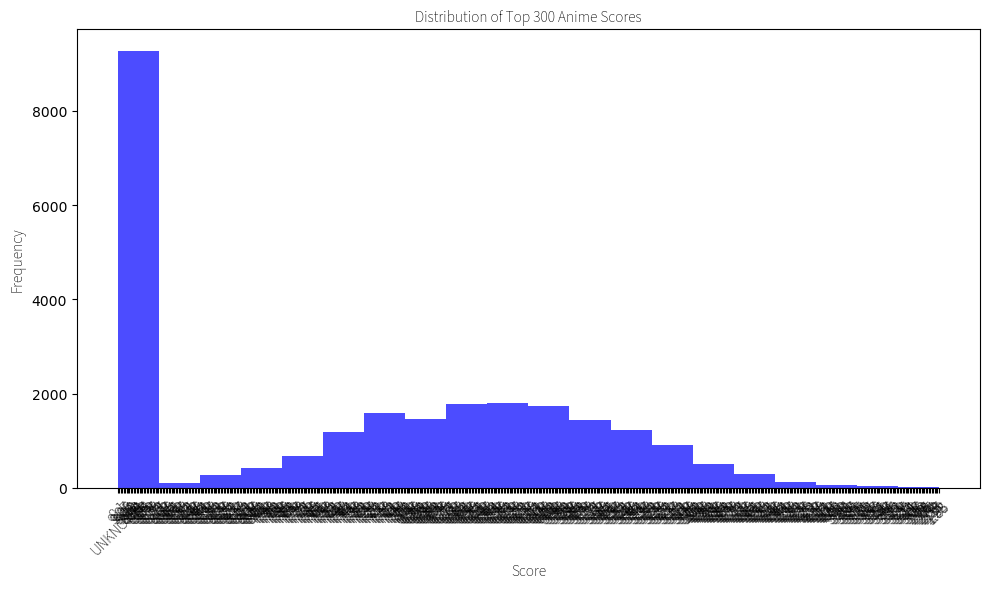

In [9]:
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties

# Specify the font properties that include Japanese character support
japanese_font = FontProperties(fname='/Users/kaushik/Desktop/Data/Noto_Sans_JP/NotoSansJP-VariableFont_wght.ttf')

# Create the plot using the top 300 scores
plt.figure(figsize=(10, 6))
plt.hist(top_300_anime['Score'], bins=20, color='blue', alpha=0.7)  # Use top_100_anime for histogram
plt.title('Distribution of Top 300 Anime Scores', fontproperties=japanese_font)
plt.xlabel('Score', fontproperties=japanese_font)
plt.ylabel('Frequency', fontproperties=japanese_font)

# Rotate x-axis labels to prevent overlap and ensure visibility
plt.xticks(rotation=45, fontproperties=japanese_font)  # Rotate labels for better visibility
plt.tight_layout()  # Adjust layout to make room for label

# Show the plot
plt.show()


In [10]:
from pyspark.sql.functions import regexp_replace

# Remove non-numeric characters from 'Score' column before casting
anime_df = anime_df.withColumn("Score", regexp_replace("Score", "[^0-9.]", ""))

# Cast the 'Score' column to float again
anime_df = anime_df.withColumn("Score", col("Score").cast("float"))


In [11]:
from pyspark.sql.functions import col

# Assuming anime_df is your DataFrame
# Cast the 'Score' column to float
anime_df = anime_df.withColumn("Score", col("Score").cast("float"))

# Now you can safely calculate the average
genre_average_score = anime_df.groupBy("Genres").avg("Score").orderBy("avg(Score)", ascending=False)

# Show top 10 genres by average score
genre_average_score.show(10)


+--------------------+-----------------+
|              Genres|       avg(Score)|
+--------------------+-----------------+
|action adventure ...|8.670000076293945|
|action adventure ...|8.264999866485596|
|adventure award w...|             8.25|
|mystery supernatu...|8.180000305175781|
|drama slice of li...|8.176666736602783|
|adventure comedy ...|8.039999961853027|
|drama romance sports|              8.0|
|comedy drama myst...|7.980000019073486|
|action award winn...|7.940000057220459|
|action adventure ...|7.900000095367432|
+--------------------+-----------------+
only showing top 10 rows



In [12]:
from pyspark.sql.functions import explode, split, lower

genre_count = anime_df.groupBy("Genres").count().orderBy("count", ascending=False)
genre_average_score = anime_df.groupBy("Genres").avg("Score").orderBy("avg(Score)", ascending=False)

# Show top 10 genres by popularity and score
genre_count.show(10)
genre_average_score.show(10)


+--------------------+-----+
|              Genres|count|
+--------------------+-----+
|             unknown| 4179|
|              comedy| 1579|
|             fantasy| 1068|
|              hentai|  574|
|         avant garde|  438|
|       slice of life|  391|
|               drama|  364|
|   adventure fantasy|  357|
|      comedy fantasy|  289|
|comedy slice of life|  283|
+--------------------+-----+
only showing top 10 rows

+--------------------+-----------------+
|              Genres|       avg(Score)|
+--------------------+-----------------+
|action adventure ...|8.670000076293945|
|action adventure ...|8.264999866485596|
|adventure award w...|             8.25|
|mystery supernatu...|8.180000305175781|
|drama slice of li...|8.176666736602783|
|adventure comedy ...|8.039999961853027|
|drama romance sports|              8.0|
|comedy drama myst...|7.980000019073486|
|action award winn...|7.940000057220459|
|action adventure ...|7.900000095367432|
+--------------------+-------------

In [13]:
from pyspark.sql.functions import col

# Assuming anime_df is your DataFrame
# Cast 'Popularity', 'Favorites', and 'Episodes' to integers if they are not already
anime_df = anime_df.withColumn("Popularity", col("Popularity").cast("int"))
anime_df = anime_df.withColumn("Favorites", col("Favorites").cast("int"))
anime_df = anime_df.withColumn("Episodes", col("Episodes").cast("int"))
anime_df = anime_df.withColumn("Score", col("Score").cast("float"))  # Ensuring Score is a float

# Print the schema to check if the casts were successful
anime_df.printSchema()


root
 |-- _c0: string (nullable = true)
 |-- anime_id: string (nullable = true)
 |-- Name: string (nullable = true)
 |-- English name: string (nullable = true)
 |-- Other name: string (nullable = true)
 |-- Score: float (nullable = true)
 |-- Genres: string (nullable = false)
 |-- Synopsis: string (nullable = true)
 |-- Type: string (nullable = true)
 |-- Episodes: integer (nullable = true)
 |-- Aired: string (nullable = true)
 |-- Premiered: string (nullable = true)
 |-- Status: string (nullable = true)
 |-- Producers: string (nullable = true)
 |-- Licensors: string (nullable = true)
 |-- Studios: string (nullable = true)
 |-- Source: string (nullable = true)
 |-- Duration: string (nullable = true)
 |-- Rating: string (nullable = true)
 |-- Rank: string (nullable = true)
 |-- Popularity: integer (nullable = true)
 |-- Favorites: integer (nullable = true)
 |-- Scored By: string (nullable = true)
 |-- Members: integer (nullable = true)
 |-- Image URL: string (nullable = true)
 |-- Year:

In [14]:
from pyspark.ml.feature import VectorAssembler

features = ["Score", "Popularity", "Favorites", "Episodes"]
assembler = VectorAssembler(inputCols=features, outputCol="features")
feature_df = assembler.transform(anime_df).select("features")

# Now the VectorAssembler should not throw an error


In [17]:
# Checking for null values in the columns used
for column in features:
    null_count = anime_df.filter(col(column).isNull()).count()
    print(f"Number of null values in column {column}: {null_count}")


Number of null values in column Score: 0
Number of null values in column Popularity: 0
Number of null values in column Favorites: 0
Number of null values in column Episodes: 0


In [16]:
# Fill nulls with 0 or another suitable value
anime_df = anime_df.fillna(0, subset=features)


In [18]:
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler

features = ["Score", "Popularity", "Favorites", "Episodes"]
assembler = VectorAssembler(inputCols=features, outputCol="features")
feature_df = assembler.transform(anime_df).select("features")

corr_matrix = Correlation.corr(feature_df, "features").head()
print("Pearson correlation matrix:\n" + str(corr_matrix[0]))


24/05/03 02:38:24 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS


Pearson correlation matrix:
DenseMatrix([[ 1.        , -0.76627508,  0.09620578, -0.15182186],
             [-0.76627508,  1.        , -0.1477317 ,  0.18863917],
             [ 0.09620578, -0.1477317 ,  1.        , -0.00254122],
             [-0.15182186,  0.18863917, -0.00254122,  1.        ]])


In [19]:
from pyspark.sql.functions import avg, count

user_engagement = users_df.groupBy("Gender").agg(
    avg("Days Watched").alias("Avg Days Watched"),
    avg("Completed").alias("Avg Completed"),
    count("Gender").alias("Count")
).orderBy("Avg Days Watched", ascending=False)

user_engagement.show()


+----------+------------------+------------------+------+
|    Gender|  Avg Days Watched|     Avg Completed| Count|
+----------+------------------+------------------+------+
|Non-Binary| 85.27866520787748| 288.7757111597374|   914|
|      Male| 65.49853680049134|187.51603376856562|126984|
|    Female| 38.55076648804405|103.64841053493507| 96485|
|   Unknown|10.985404226021762| 27.92483236570022|506907|
+----------+------------------+------------------+------+



In [20]:
from pyspark.sql.functions import year

anime_df = anime_df.withColumn("Year", year("Aired"))
yearly_avg_scores = anime_df.groupBy("Year").avg("Score").orderBy("Year")

yearly_avg_scores.show()


+----+------------------+
|Year|        avg(Score)|
+----+------------------+
|NULL| 3.081540444523067|
|1917|               0.0|
|1924|               0.0|
|1925|2.1280000686645506|
|1926| 3.822499990463257|
|1927|               0.0|
|1928|5.0299999713897705|
|1929| 3.353333314259847|
|1930| 5.380000114440918|
|1931|   4.0623077245859|
|1932| 4.898571355002267|
|1933| 4.967142854418073|
|1934| 3.292500138282776|
|1935|3.7477777269151478|
|1936| 4.165000081062317|
|1937| 5.070000171661377|
|1938| 5.239999771118164|
|1939|2.4749999046325684|
|1940| 5.019999980926514|
|1941| 5.150000095367432|
+----+------------------+
only showing top 20 rows



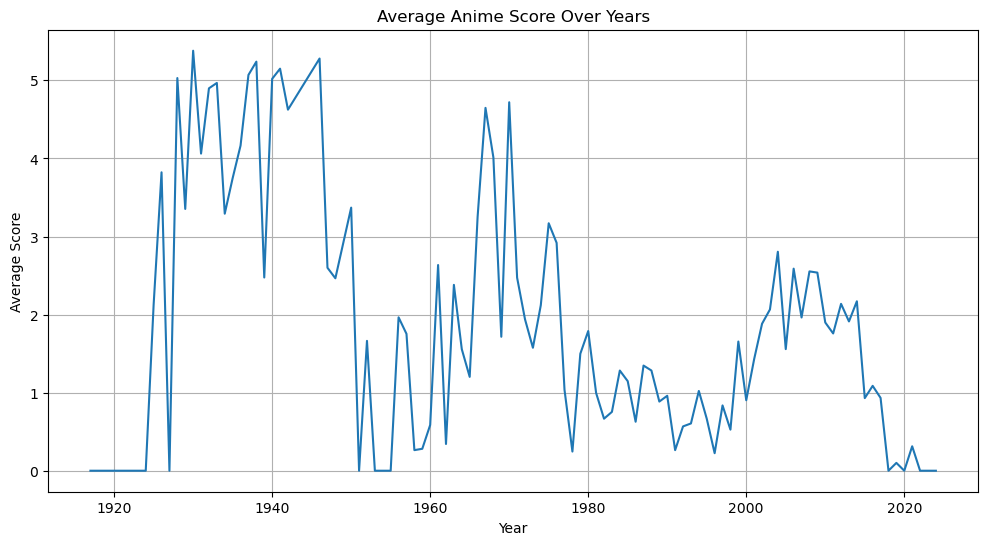

24/05/03 06:15:58 WARN HeartbeatReceiver: Removing executor driver with no recent heartbeats: 1634198 ms exceeds timeout 120000 ms
24/05/03 06:15:58 WARN SparkContext: Killing executors is not supported by current scheduler.
24/05/03 06:16:00 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:56)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:310)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:124)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$

24/05/03 06:49:13 WARN Executor: Issue communicating with driver in heartbeater
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:56)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:310)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:101)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:85)
	at org.apache.spark.storage.BlockManagerMaster.registerBlockManager(BlockManagerMaster.scala:80)
	at org.apache.spark.storage.BlockManager.reregister(BlockManager.scala:642)
	at org.apache.spark.executor.Executor.reportHeartBeat(Executor.scala:1223)
	at org.apache.spark.executor.Executor.$anonfun$heartbeater$1(Executor.scala:295)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.util.Utils$.logUncaughtExceptions(Utils.scala:1928)

24/05/03 07:05:53 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:56)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:310)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:124)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:123)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:688)
	at org.apache.spark.storage.BlockManagerMasterE

24/05/03 07:17:06 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:56)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:310)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:124)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:123)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:688)
	at org.apache.spark.storage.BlockManagerMasterE

24/05/03 07:34:35 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:56)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:310)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:124)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:123)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:688)
	at org.apache.spark.storage.BlockManagerMasterE

24/05/03 07:43:54 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:56)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:310)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:124)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:123)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:688)
	at org.apache.spark.storage.BlockManagerMasterE

24/05/03 08:14:43 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:56)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:310)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:124)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:123)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:688)
	at org.apache.spark.storage.BlockManagerMasterE

24/05/03 08:15:02 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:56)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:310)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:124)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:123)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:688)
	at org.apache.spark.storage.BlockManagerMasterE

24/05/03 08:18:01 WARN Executor: Issue communicating with driver in heartbeater
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:56)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:310)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:101)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:85)
	at org.apache.spark.storage.BlockManagerMaster.registerBlockManager(BlockManagerMaster.scala:80)
	at org.apache.spark.storage.BlockManager.reregister(BlockManager.scala:642)
	at org.apache.spark.executor.Executor.reportHeartBeat(Executor.scala:1223)
	at org.apache.spark.executor.Executor.$anonfun$heartbeater$1(Executor.scala:295)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.util.Utils$.logUncaughtExceptions(Utils.scala:1928)

24/05/03 08:35:34 WARN Executor: Issue communicating with driver in heartbeater
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:56)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:310)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:101)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:85)
	at org.apache.spark.storage.BlockManagerMaster.registerBlockManager(BlockManagerMaster.scala:80)
	at org.apache.spark.storage.BlockManager.reregister(BlockManager.scala:642)
	at org.apache.spark.executor.Executor.reportHeartBeat(Executor.scala:1223)
	at org.apache.spark.executor.Executor.$anonfun$heartbeater$1(Executor.scala:295)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.util.Utils$.logUncaughtExceptions(Utils.scala:1928)

24/05/03 08:55:10 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:56)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:310)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:124)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:123)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:688)
	at org.apache.spark.storage.BlockManagerMasterE

24/05/03 09:18:57 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:56)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:310)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:124)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:123)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:688)
	at org.apache.spark.storage.BlockManagerMasterE

24/05/03 09:34:04 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:56)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:310)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:124)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:123)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:688)
	at org.apache.spark.storage.BlockManagerMasterE

24/05/03 10:06:07 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:56)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:310)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:124)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:123)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:688)
	at org.apache.spark.storage.BlockManagerMasterE

24/05/03 10:12:02 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:56)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:310)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:124)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:123)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:688)
	at org.apache.spark.storage.BlockManagerMasterE

24/05/03 10:19:58 WARN Executor: Issue communicating with driver in heartbeater
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:56)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:310)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:101)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:85)
	at org.apache.spark.storage.BlockManagerMaster.registerBlockManager(BlockManagerMaster.scala:80)
	at org.apache.spark.storage.BlockManager.reregister(BlockManager.scala:642)
	at org.apache.spark.executor.Executor.reportHeartBeat(Executor.scala:1223)
	at org.apache.spark.executor.Executor.$anonfun$heartbeater$1(Executor.scala:295)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.util.Utils$.logUncaughtExceptions(Utils.scala:1928)

24/05/03 10:35:46 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:56)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:310)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:124)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:123)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:688)
	at org.apache.spark.storage.BlockManagerMasterE

24/05/03 10:52:24 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:56)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:310)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:124)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:123)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:688)
	at org.apache.spark.storage.BlockManagerMasterE

24/05/03 10:52:41 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:56)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:310)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:124)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:123)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:688)
	at org.apache.spark.storage.BlockManagerMasterE

24/05/03 10:52:53 WARN Executor: Issue communicating with driver in heartbeater
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:56)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:310)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:101)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:85)
	at org.apache.spark.storage.BlockManagerMaster.registerBlockManager(BlockManagerMaster.scala:80)
	at org.apache.spark.storage.BlockManager.reregister(BlockManager.scala:642)
	at org.apache.spark.executor.Executor.reportHeartBeat(Executor.scala:1223)
	at org.apache.spark.executor.Executor.$anonfun$heartbeater$1(Executor.scala:295)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.util.Utils$.logUncaughtExceptions(Utils.scala:1928)

24/05/03 11:09:49 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:56)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:310)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:124)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:123)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:688)
	at org.apache.spark.storage.BlockManagerMasterE

24/05/03 11:10:05 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:56)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:310)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:124)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:123)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:688)
	at org.apache.spark.storage.BlockManagerMasterE

24/05/03 11:36:49 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:56)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:310)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:124)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:123)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:688)
	at org.apache.spark.storage.BlockManagerMasterE

24/05/03 12:09:15 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:56)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:310)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:124)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:123)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:688)
	at org.apache.spark.storage.BlockManagerMasterE

24/05/03 12:22:02 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:56)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:310)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:124)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:123)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:688)
	at org.apache.spark.storage.BlockManagerMasterE

24/05/03 12:36:19 WARN Executor: Issue communicating with driver in heartbeater
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:56)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:310)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:101)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:85)
	at org.apache.spark.storage.BlockManagerMaster.registerBlockManager(BlockManagerMaster.scala:80)
	at org.apache.spark.storage.BlockManager.reregister(BlockManager.scala:642)
	at org.apache.spark.executor.Executor.reportHeartBeat(Executor.scala:1223)
	at org.apache.spark.executor.Executor.$anonfun$heartbeater$1(Executor.scala:295)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.util.Utils$.logUncaughtExceptions(Utils.scala:1928)

24/05/03 12:36:42 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:56)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:310)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:124)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:123)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:688)
	at org.apache.spark.storage.BlockManagerMasterE

24/05/03 12:36:54 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:56)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:310)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:124)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:123)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:688)
	at org.apache.spark.storage.BlockManagerMasterE

24/05/03 12:38:14 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:56)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:310)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:124)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:123)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:688)
	at org.apache.spark.storage.BlockManagerMasterE

24/05/03 12:45:19 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:56)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:310)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:124)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:123)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:688)
	at org.apache.spark.storage.BlockManagerMasterE

24/05/03 12:46:26 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:56)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:310)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:124)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:123)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:688)
	at org.apache.spark.storage.BlockManagerMasterE

24/05/03 12:46:36 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:56)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:310)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:124)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:123)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:688)
	at org.apache.spark.storage.BlockManagerMasterE

24/05/03 12:47:01 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:56)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:310)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:124)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:123)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:688)
	at org.apache.spark.storage.BlockManagerMasterE

24/05/03 12:47:18 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:56)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:310)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:124)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:123)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:688)
	at org.apache.spark.storage.BlockManagerMasterE

24/05/03 12:48:02 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:56)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:310)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:124)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:123)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:688)
	at org.apache.spark.storage.BlockManagerMasterE

24/05/03 12:48:39 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:56)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:310)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:124)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:123)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:688)
	at org.apache.spark.storage.BlockManagerMasterE

24/05/03 12:49:13 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:56)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:310)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:124)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:123)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:688)
	at org.apache.spark.storage.BlockManagerMasterE

24/05/03 12:49:54 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:56)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:310)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:124)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:123)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:688)
	at org.apache.spark.storage.BlockManagerMasterE

24/05/03 12:50:18 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:56)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:310)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:124)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:123)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:688)
	at org.apache.spark.storage.BlockManagerMasterE

24/05/03 12:51:19 WARN Executor: Issue communicating with driver in heartbeater
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:56)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:310)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:101)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:85)
	at org.apache.spark.storage.BlockManagerMaster.registerBlockManager(BlockManagerMaster.scala:80)
	at org.apache.spark.storage.BlockManager.reregister(BlockManager.scala:642)
	at org.apache.spark.executor.Executor.reportHeartBeat(Executor.scala:1223)
	at org.apache.spark.executor.Executor.$anonfun$heartbeater$1(Executor.scala:295)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.util.Utils$.logUncaughtExceptions(Utils.scala:1928)

24/05/03 13:08:43 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:56)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:310)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:124)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:123)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:688)
	at org.apache.spark.storage.BlockManagerMasterE

24/05/03 13:23:00 WARN Executor: Issue communicating with driver in heartbeater
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:56)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:310)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:101)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:85)
	at org.apache.spark.storage.BlockManagerMaster.registerBlockManager(BlockManagerMaster.scala:80)
	at org.apache.spark.storage.BlockManager.reregister(BlockManager.scala:642)
	at org.apache.spark.executor.Executor.reportHeartBeat(Executor.scala:1223)
	at org.apache.spark.executor.Executor.$anonfun$heartbeater$1(Executor.scala:295)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.util.Utils$.logUncaughtExceptions(Utils.scala:1928)

24/05/03 13:54:51 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:56)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:310)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:124)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:123)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:688)
	at org.apache.spark.storage.BlockManagerMasterE

24/05/03 14:04:26 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:56)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:310)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:124)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:123)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:688)
	at org.apache.spark.storage.BlockManagerMasterE

24/05/03 14:22:51 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:56)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:310)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:124)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:123)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:688)
	at org.apache.spark.storage.BlockManagerMasterE

24/05/03 14:24:02 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:56)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:310)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:124)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:123)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:688)
	at org.apache.spark.storage.BlockManagerMasterE

24/05/03 14:47:23 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:56)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:310)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:124)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:123)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:688)
	at org.apache.spark.storage.BlockManagerMasterE

24/05/03 15:02:34 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:56)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:310)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:124)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:123)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:688)
	at org.apache.spark.storage.BlockManagerMasterE

24/05/03 15:25:00 WARN Executor: Issue communicating with driver in heartbeater
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:56)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:310)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:101)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:85)
	at org.apache.spark.storage.BlockManagerMaster.registerBlockManager(BlockManagerMaster.scala:80)
	at org.apache.spark.storage.BlockManager.reregister(BlockManager.scala:642)
	at org.apache.spark.executor.Executor.reportHeartBeat(Executor.scala:1223)
	at org.apache.spark.executor.Executor.$anonfun$heartbeater$1(Executor.scala:295)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.util.Utils$.logUncaughtExceptions(Utils.scala:1928)

24/05/03 15:42:42 WARN Executor: Issue communicating with driver in heartbeater
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:56)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:310)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:101)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:85)
	at org.apache.spark.storage.BlockManagerMaster.registerBlockManager(BlockManagerMaster.scala:80)
	at org.apache.spark.storage.BlockManager.reregister(BlockManager.scala:642)
	at org.apache.spark.executor.Executor.reportHeartBeat(Executor.scala:1223)
	at org.apache.spark.executor.Executor.$anonfun$heartbeater$1(Executor.scala:295)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.util.Utils$.logUncaughtExceptions(Utils.scala:1928)

24/05/03 16:09:25 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:56)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:310)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:124)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:123)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:688)
	at org.apache.spark.storage.BlockManagerMasterE

24/05/03 16:11:58 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:56)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:310)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:124)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:123)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:688)
	at org.apache.spark.storage.BlockManagerMasterE

24/05/03 16:12:10 WARN Executor: Issue communicating with driver in heartbeater
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:56)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:310)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:101)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:85)
	at org.apache.spark.storage.BlockManagerMaster.registerBlockManager(BlockManagerMaster.scala:80)
	at org.apache.spark.storage.BlockManager.reregister(BlockManager.scala:642)
	at org.apache.spark.executor.Executor.reportHeartBeat(Executor.scala:1223)
	at org.apache.spark.executor.Executor.$anonfun$heartbeater$1(Executor.scala:295)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.util.Utils$.logUncaughtExceptions(Utils.scala:1928)

24/05/03 16:17:00 WARN Executor: Issue communicating with driver in heartbeater
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:56)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:310)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:101)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:85)
	at org.apache.spark.storage.BlockManagerMaster.registerBlockManager(BlockManagerMaster.scala:80)
	at org.apache.spark.storage.BlockManager.reregister(BlockManager.scala:642)
	at org.apache.spark.executor.Executor.reportHeartBeat(Executor.scala:1223)
	at org.apache.spark.executor.Executor.$anonfun$heartbeater$1(Executor.scala:295)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.util.Utils$.logUncaughtExceptions(Utils.scala:1928)

24/05/03 16:17:15 WARN Executor: Issue communicating with driver in heartbeater
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:56)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:310)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:101)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:85)
	at org.apache.spark.storage.BlockManagerMaster.registerBlockManager(BlockManagerMaster.scala:80)
	at org.apache.spark.storage.BlockManager.reregister(BlockManager.scala:642)
	at org.apache.spark.executor.Executor.reportHeartBeat(Executor.scala:1223)
	at org.apache.spark.executor.Executor.$anonfun$heartbeater$1(Executor.scala:295)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.util.Utils$.logUncaughtExceptions(Utils.scala:1928)

24/05/03 16:26:06 WARN Executor: Issue communicating with driver in heartbeater
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:56)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:310)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:101)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:85)
	at org.apache.spark.storage.BlockManagerMaster.registerBlockManager(BlockManagerMaster.scala:80)
	at org.apache.spark.storage.BlockManager.reregister(BlockManager.scala:642)
	at org.apache.spark.executor.Executor.reportHeartBeat(Executor.scala:1223)
	at org.apache.spark.executor.Executor.$anonfun$heartbeater$1(Executor.scala:295)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.util.Utils$.logUncaughtExceptions(Utils.scala:1928)

24/05/03 16:51:23 WARN Executor: Issue communicating with driver in heartbeater
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:56)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:310)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:101)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:85)
	at org.apache.spark.storage.BlockManagerMaster.registerBlockManager(BlockManagerMaster.scala:80)
	at org.apache.spark.storage.BlockManager.reregister(BlockManager.scala:642)
	at org.apache.spark.executor.Executor.reportHeartBeat(Executor.scala:1223)
	at org.apache.spark.executor.Executor.$anonfun$heartbeater$1(Executor.scala:295)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.util.Utils$.logUncaughtExceptions(Utils.scala:1928)

24/05/03 17:08:40 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:56)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:310)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:124)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:123)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:688)
	at org.apache.spark.storage.BlockManagerMasterE

24/05/03 17:27:05 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:56)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:310)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:124)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:123)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:688)
	at org.apache.spark.storage.BlockManagerMasterE

24/05/03 17:44:31 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:56)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:310)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:124)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:123)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:688)
	at org.apache.spark.storage.BlockManagerMasterE

In [21]:
import seaborn as sns

pd_yearly_scores = yearly_avg_scores.toPandas()

plt.figure(figsize=(12, 6))
sns.lineplot(x='Year', y='avg(Score)', data=pd_yearly_scores)
plt.title('Average Anime Score Over Years')
plt.xlabel('Year')
plt.ylabel('Average Score')
plt.grid(True)
plt.show()


In [38]:
anime = spark.read.csv("/Users/kaushik/Desktop/Data/anime-filtered_new.csv", header=True, inferSchema=True)


In [39]:
print("Rows:", anime.count())
print("Columns:", len(anime.columns))


Rows: 14952
Columns: 26


In [40]:
anime.printSchema()


root
 |-- _c0: integer (nullable = true)
 |-- anime_id: integer (nullable = true)
 |-- Name: string (nullable = true)
 |-- Score: double (nullable = true)
 |-- Genres: string (nullable = true)
 |-- English name: string (nullable = true)
 |-- Japanese name: string (nullable = true)
 |-- sypnopsis: string (nullable = true)
 |-- Type: string (nullable = true)
 |-- Episodes: string (nullable = true)
 |-- Aired: string (nullable = true)
 |-- Premiered: string (nullable = true)
 |-- Producers: string (nullable = true)
 |-- Licensors: string (nullable = true)
 |-- Studios: string (nullable = true)
 |-- Source: string (nullable = true)
 |-- Duration: string (nullable = true)
 |-- Rating: string (nullable = true)
 |-- Ranked: double (nullable = true)
 |-- Popularity: integer (nullable = true)
 |-- Members: integer (nullable = true)
 |-- Favorites: integer (nullable = true)
 |-- Watching: integer (nullable = true)
 |-- Completed: integer (nullable = true)
 |-- On-Hold: integer (nullable = true)


In [41]:
anime.describe().show()


24/05/02 21:17:47 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , anime_id, Name, Score, Genres, English name, Japanese name, sypnopsis, Type, Episodes, Aired, Premiered, Producers, Licensors, Studios, Source, Duration, Rating, Ranked, Popularity, Members, Favorites, Watching, Completed, On-Hold, Dropped
 Schema: _c0, anime_id, Name, Score, Genres, English name, Japanese name, sypnopsis, Type, Episodes, Aired, Premiered, Producers, Licensors, Studios, Source, Duration, Rating, Ranked, Popularity, Members, Favorites, Watching, Completed, On-Hold, Dropped
Expected: _c0 but found: 
CSV file: file:///Users/kaushik/Desktop/Data/anime-filtered_new.csv


+-------+-----------------+------------------+------------------+------------------+------+--------------------+-----------------+--------------------+-------+------------------+------------------+-----------+----------+-------------------+--------------------+------------+--------+------------+-----------------+-----------------+-----------------+-----------------+------------------+------------------+------------------+------------------+
|summary|              _c0|          anime_id|              Name|             Score|Genres|        English name|    Japanese name|           sypnopsis|   Type|          Episodes|             Aired|  Premiered| Producers|          Licensors|             Studios|      Source|Duration|      Rating|           Ranked|       Popularity|          Members|        Favorites|          Watching|         Completed|           On-Hold|           Dropped|
+-------+-----------------+------------------+------------------+------------------+------+-------------------

In [42]:
from pyspark.sql.functions import isnull, sum as _sum

anime.select([_sum(isnull(c).cast("int")).alias(c) for c in anime.columns]).show()


+---+--------+----+-----+------+------------+-------------+---------+----+--------+-----+---------+---------+---------+-------+------+--------+------+------+----------+-------+---------+--------+---------+-------+-------+
|_c0|anime_id|Name|Score|Genres|English name|Japanese name|sypnopsis|Type|Episodes|Aired|Premiered|Producers|Licensors|Studios|Source|Duration|Rating|Ranked|Popularity|Members|Favorites|Watching|Completed|On-Hold|Dropped|
+---+--------+----+-----+------+------------+-------------+---------+----+--------+-----+---------+---------+---------+-------+------+--------+------+------+----------+-------+---------+--------+---------+-------+-------+
|  0|       0|   0|    0|     0|           0|            0|     1350|   0|       0|    0|        0|        0|        0|      0|     0|       0|     0|  1721|         0|      0|        0|       0|        0|      0|      0|
+---+--------+----+-----+------+------------+-------------+---------+----+--------+-----+---------+---------+---

24/05/02 21:17:55 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , anime_id, Name, Score, Genres, English name, Japanese name, sypnopsis, Type, Episodes, Aired, Premiered, Producers, Licensors, Studios, Source, Duration, Rating, Ranked, Popularity, Members, Favorites, Watching, Completed, On-Hold, Dropped
 Schema: _c0, anime_id, Name, Score, Genres, English name, Japanese name, sypnopsis, Type, Episodes, Aired, Premiered, Producers, Licensors, Studios, Source, Duration, Rating, Ranked, Popularity, Members, Favorites, Watching, Completed, On-Hold, Dropped
Expected: _c0 but found: 
CSV file: file:///Users/kaushik/Desktop/Data/anime-filtered_new.csv


In [43]:
print("Duplicated Rows:", anime.count() - anime.dropDuplicates().count())


24/05/02 21:18:03 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , anime_id, Name, Score, Genres, English name, Japanese name, sypnopsis, Type, Episodes, Aired, Premiered, Producers, Licensors, Studios, Source, Duration, Rating, Ranked, Popularity, Members, Favorites, Watching, Completed, On-Hold, Dropped
 Schema: _c0, anime_id, Name, Score, Genres, English name, Japanese name, sypnopsis, Type, Episodes, Aired, Premiered, Producers, Licensors, Studios, Source, Duration, Rating, Ranked, Popularity, Members, Favorites, Watching, Completed, On-Hold, Dropped
Expected: _c0 but found: 
CSV file: file:///Users/kaushik/Desktop/Data/anime-filtered_new.csv


Duplicated Rows: 0


In [44]:
from pyspark.sql.functions import desc

def value_counts(df, column_name):
    return df.groupBy(column_name).count().orderBy(desc("count"))

value_counts(anime, "Type").show()
value_counts(anime, "Studios").show()
value_counts(anime, "Source").show()


+-------+-----+
|   Type|count|
+-------+-----+
|     TV| 4650|
|    OVA| 3364|
|  Movie| 2636|
|Special| 1991|
|    ONA| 1531|
|  Music|  744|
|Unknown|   36|
+-------+-----+

+--------------------+-----+
|             Studios|count|
+--------------------+-----+
|             Unknown| 4912|
|      Toei Animation|  695|
|             Sunrise|  477|
|           J.C.Staff|  356|
|            Madhouse|  323|
|   TMS Entertainment|  266|
|      Production I.G|  264|
|         Studio Deen|  262|
|      Studio Pierrot|  248|
|                 OLM|  210|
|    Nippon Animation|  201|
|        A-1 Pictures|  192|
|   Shin-Ei Animation|  157|
|Tatsunoko Production|  138|
|                 DLE|  133|
|               Bones|  127|
|                 AIC|  121|
|               Gonzo|  121|
|               Shaft|  119|
|     Kyoto Animation|  115|
+--------------------+-----+
only showing top 20 rows

+-------------+-----+
|       Source|count|
+-------------+-----+
|        Manga| 3764|
|     Origina

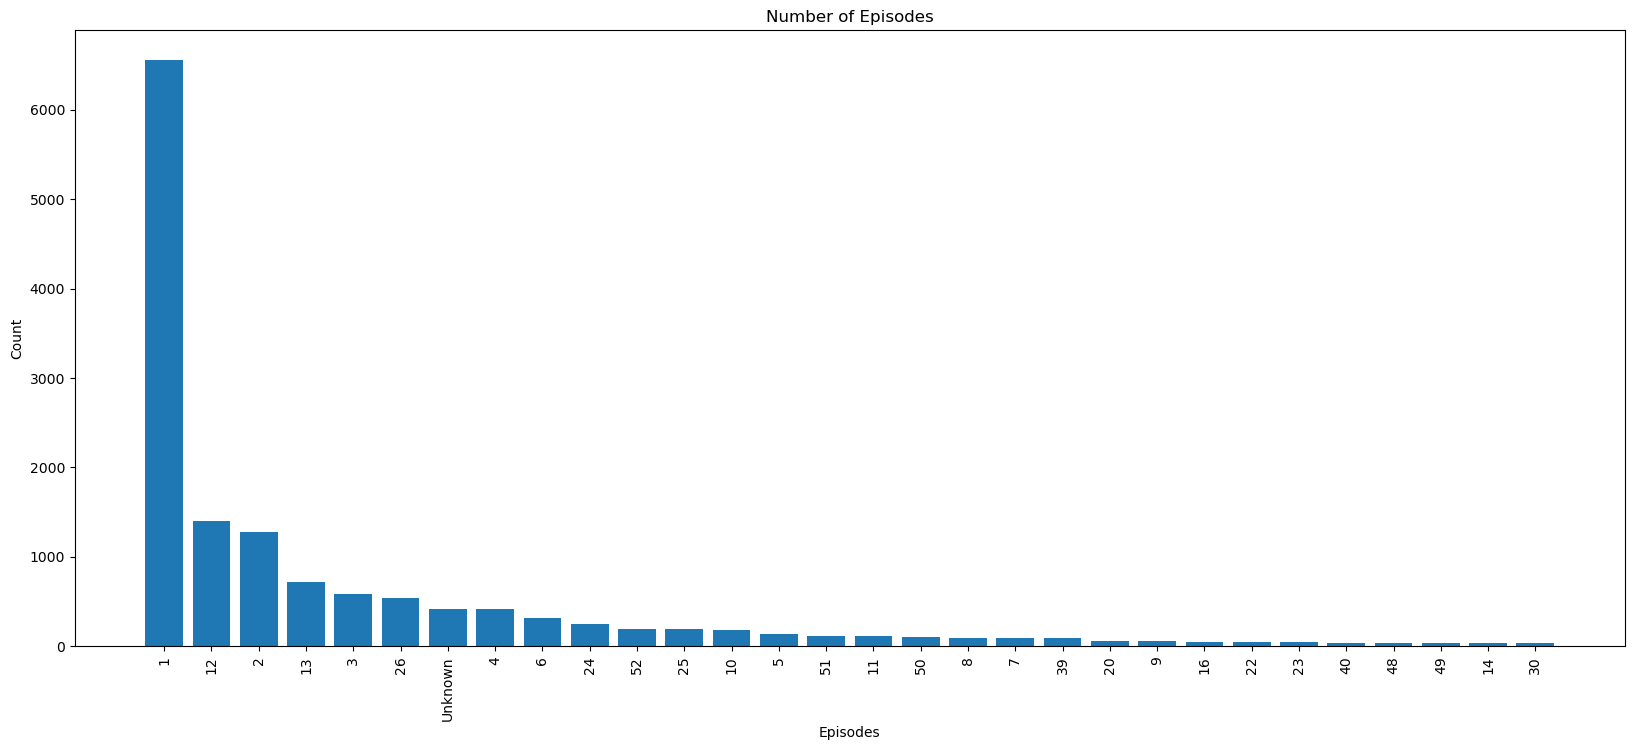

In [45]:
import matplotlib.pyplot as plt
import seaborn as sns

# Example for Episodes
episode_counts = value_counts(anime, "Episodes").limit(30).toPandas()

plt.figure(figsize=(20,8))
plt.bar(episode_counts['Episodes'], episode_counts['count'])
plt.title('Number of Episodes')
plt.xlabel('Episodes')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.show()


In [46]:
sorted_df = anime.sort(col('Score').desc())
top_40_anime = sorted_df.limit(40)

top_40_anime.select("Name", "Score", "Popularity").show()


+--------------------+-----+----------+
|                Name|Score|Popularity|
+--------------------+-----+----------+
|Fullmetal Alchemi...| 9.19|         3|
|Shingeki no Kyoji...| 9.17|       119|
|         Steins;Gate| 9.11|         9|
|Hunter x Hunter (...|  9.1|        12|
|Shingeki no Kyoji...|  9.1|        63|
|            Gintama°|  9.1|       329|
|            Gintama'| 9.08|       362|
|Ginga Eiyuu Densetsu| 9.07|       633|
| Gintama': Enchousen| 9.04|       660|
|      Koe no Katachi|  9.0|        28|
|3-gatsu no Lion 2...|  9.0|       545|
|            Gintama.| 8.99|       730|
|             Gintama| 8.96|       114|
|Gintama Movie 2: ...| 8.96|       873|
|Clannad: After Story| 8.96|        84|
|      Kimi no Na wa.| 8.96|        11|
|Owarimonogatari 2...| 8.93|       521|
|Code Geass: Hangy...| 8.91|        36|
|  Gintama: The Final| 8.88|      2987|
|Haikyuu!!: Karasu...| 8.87|       123|
+--------------------+-----+----------+
only showing top 20 rows



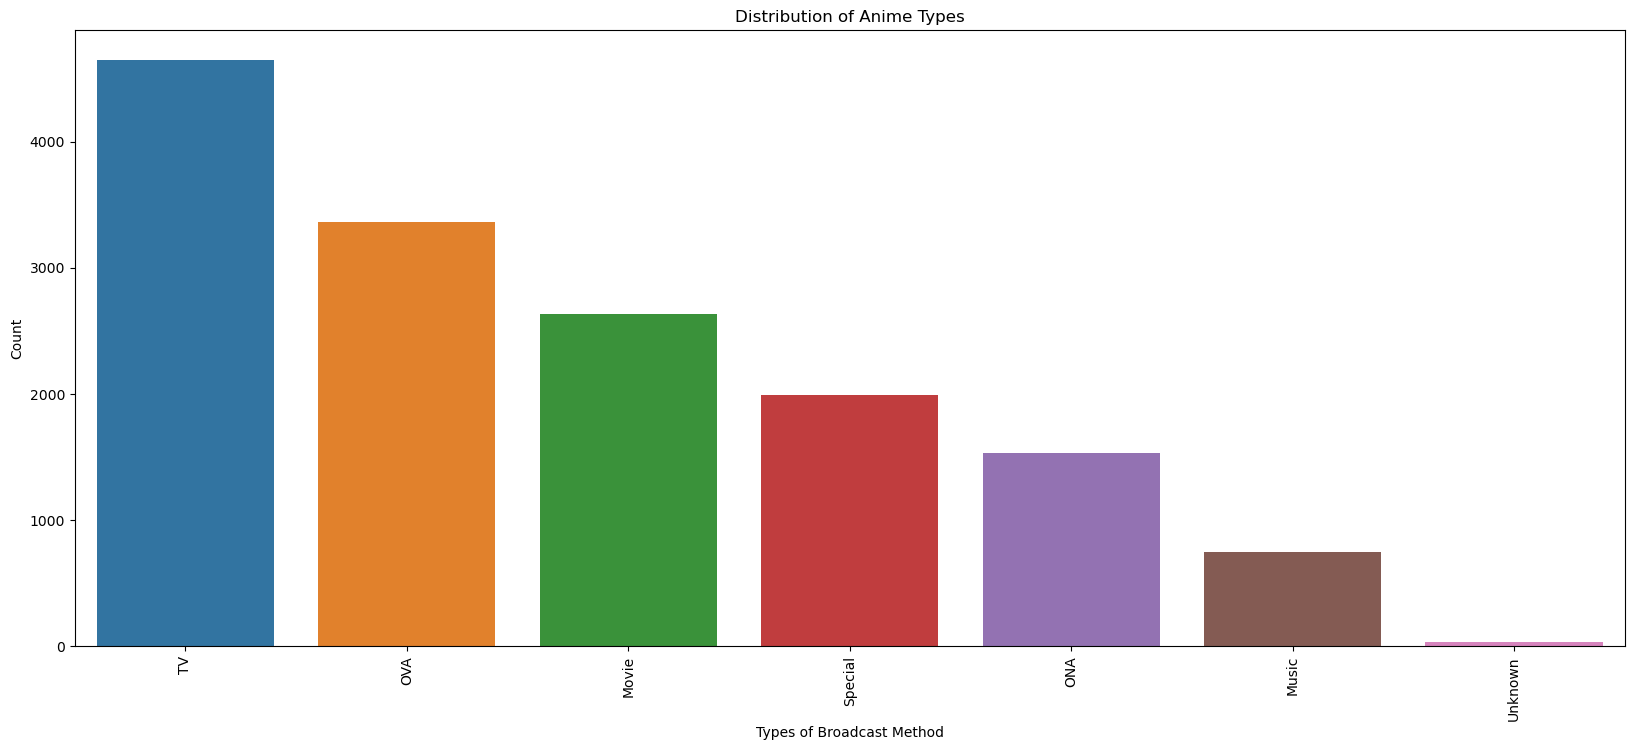

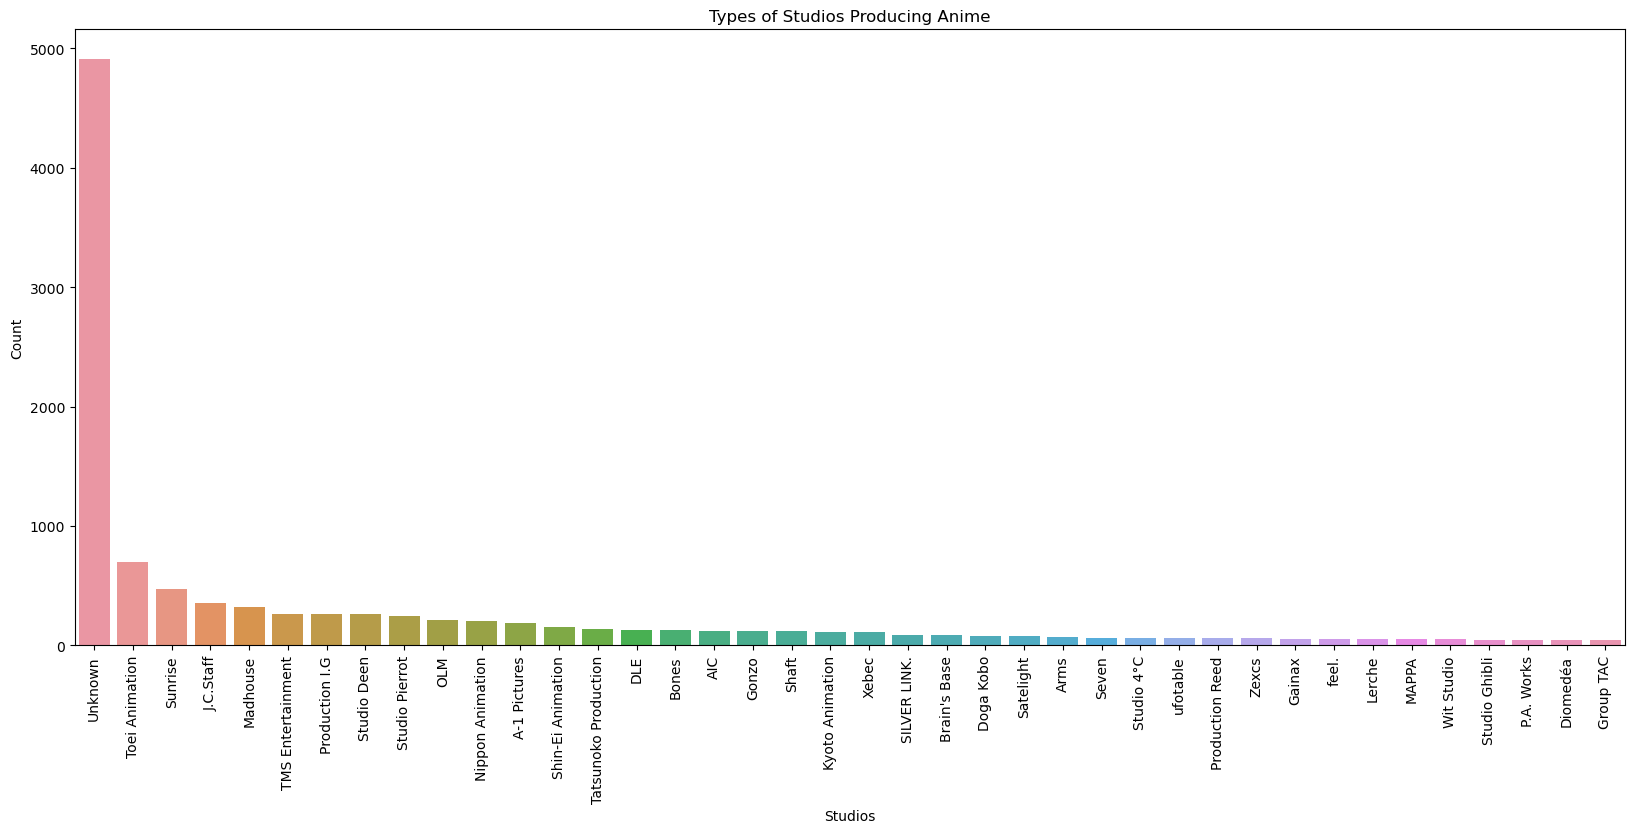

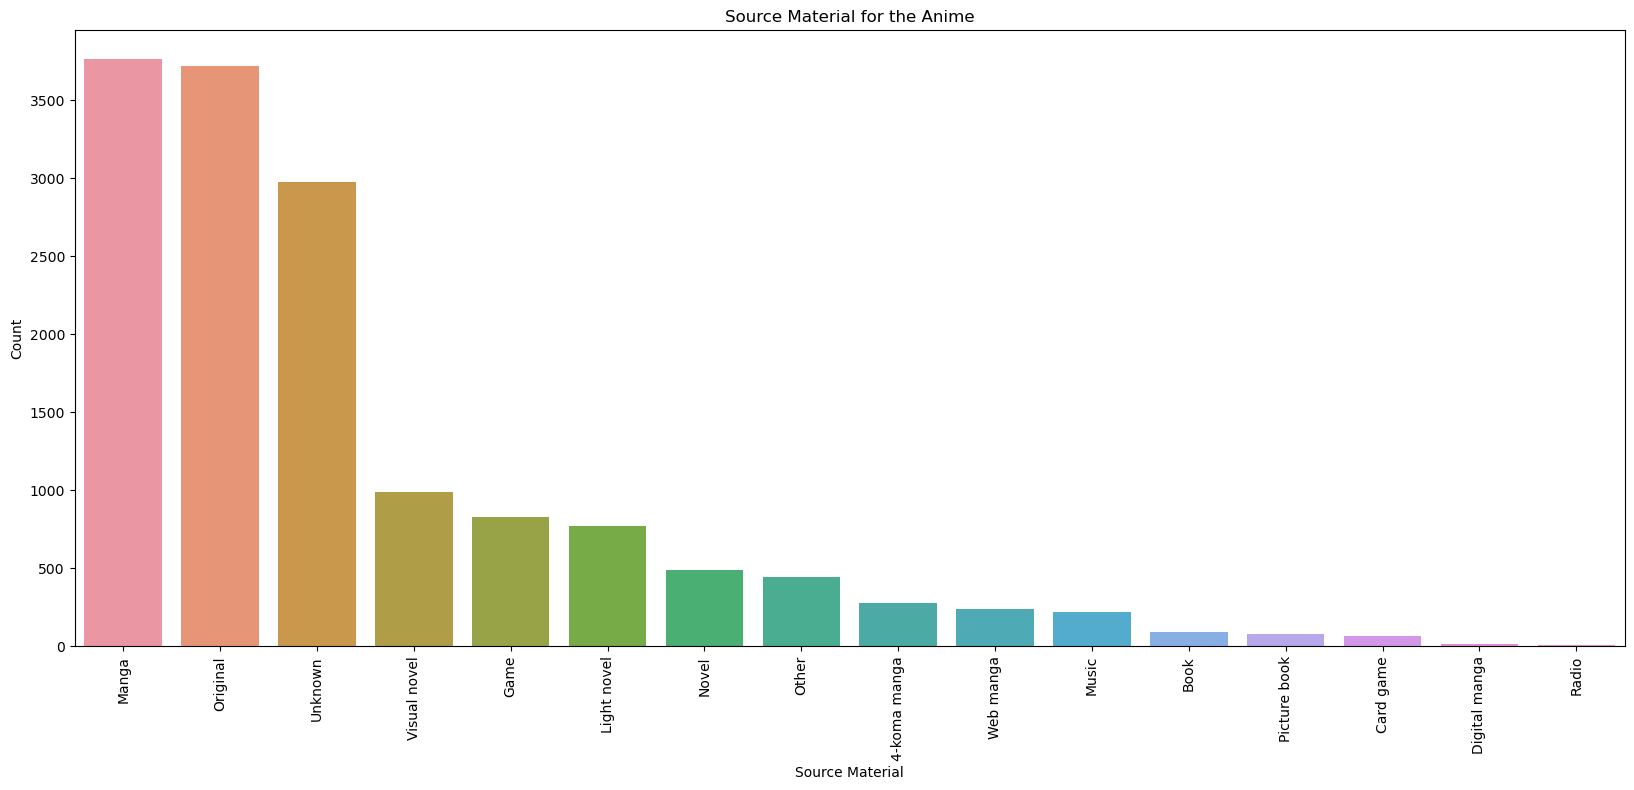

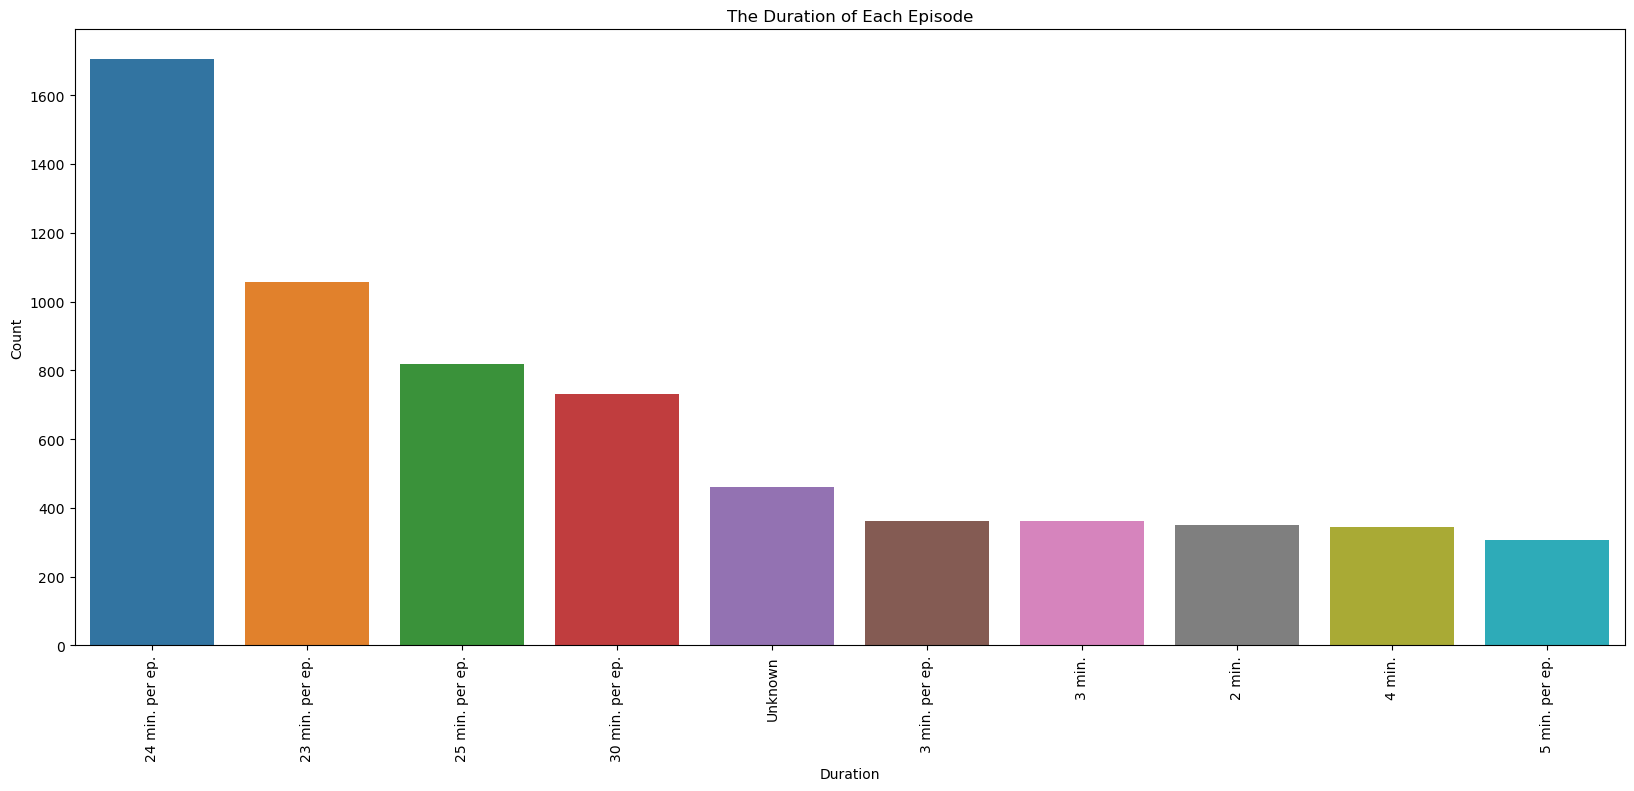

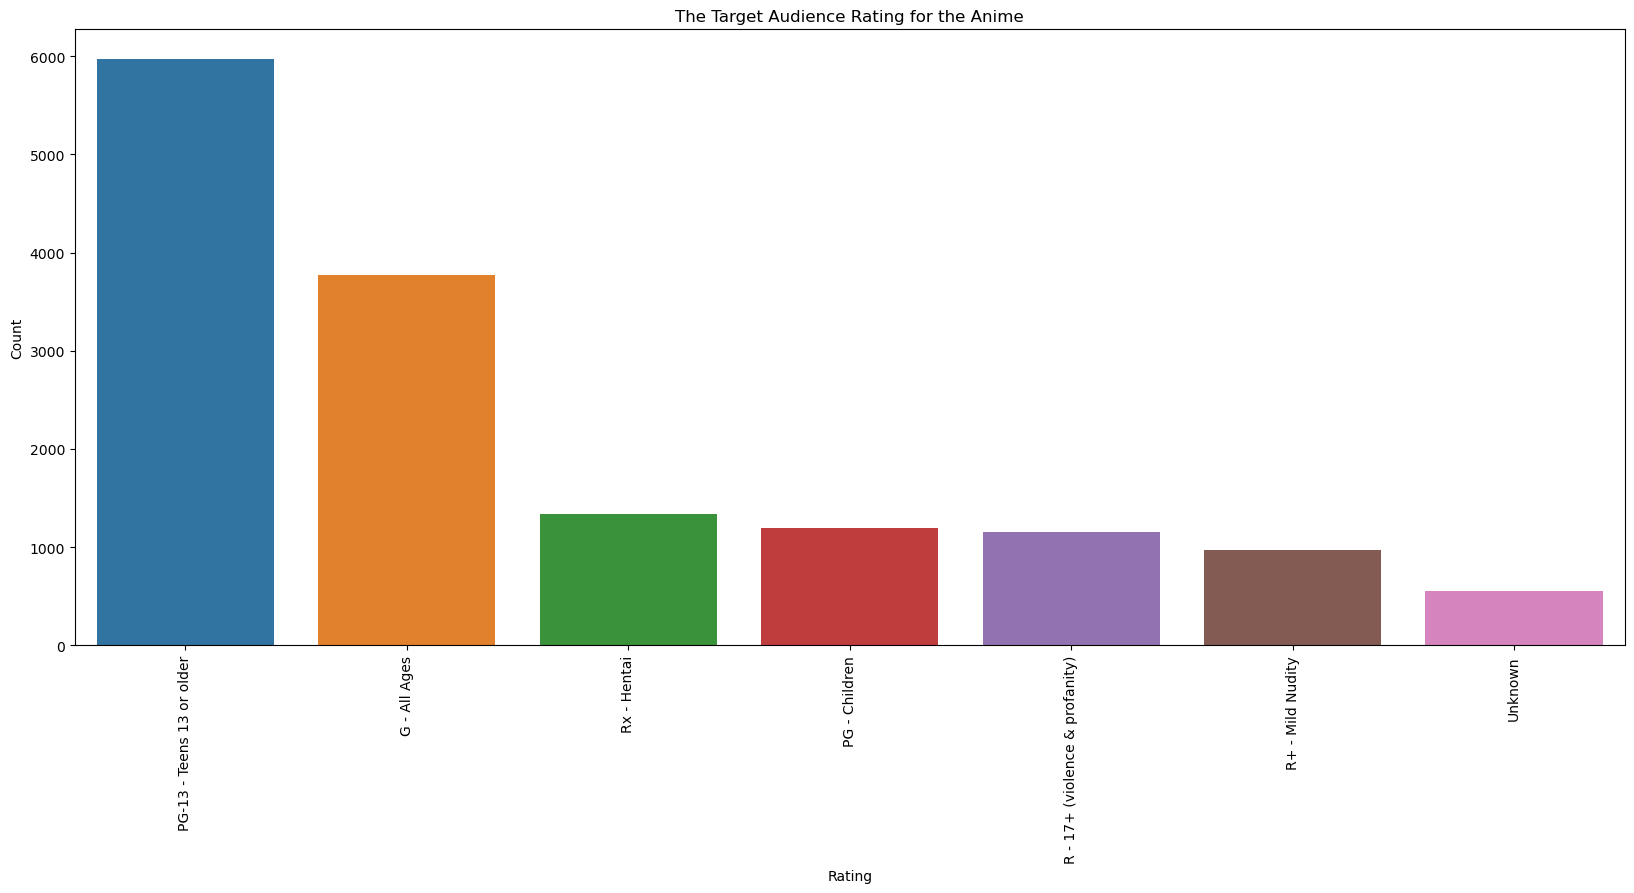

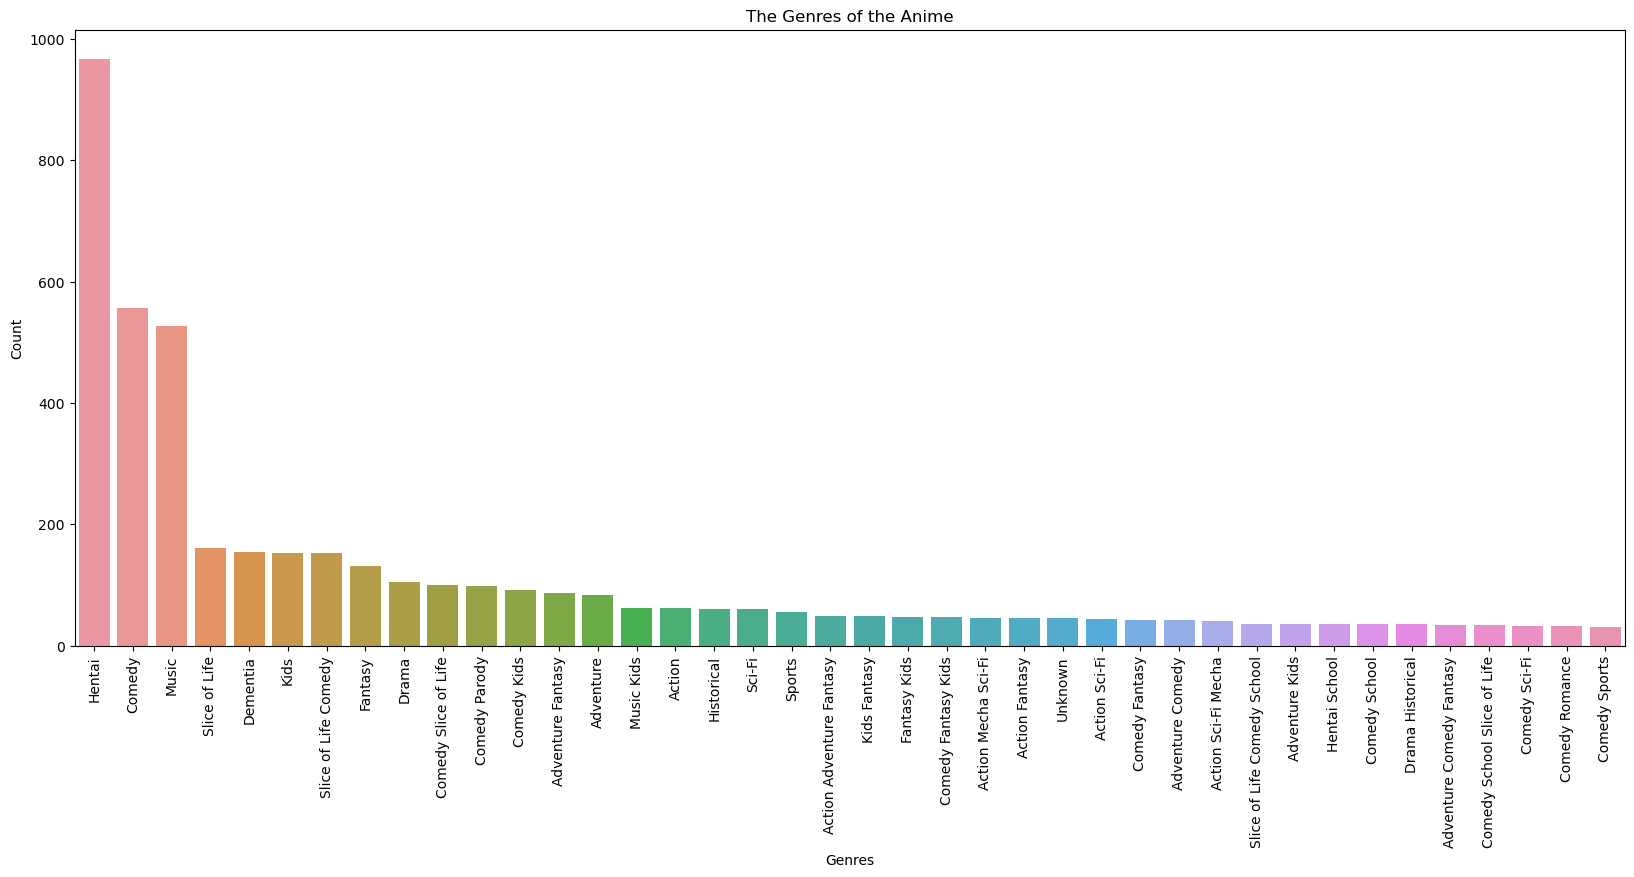

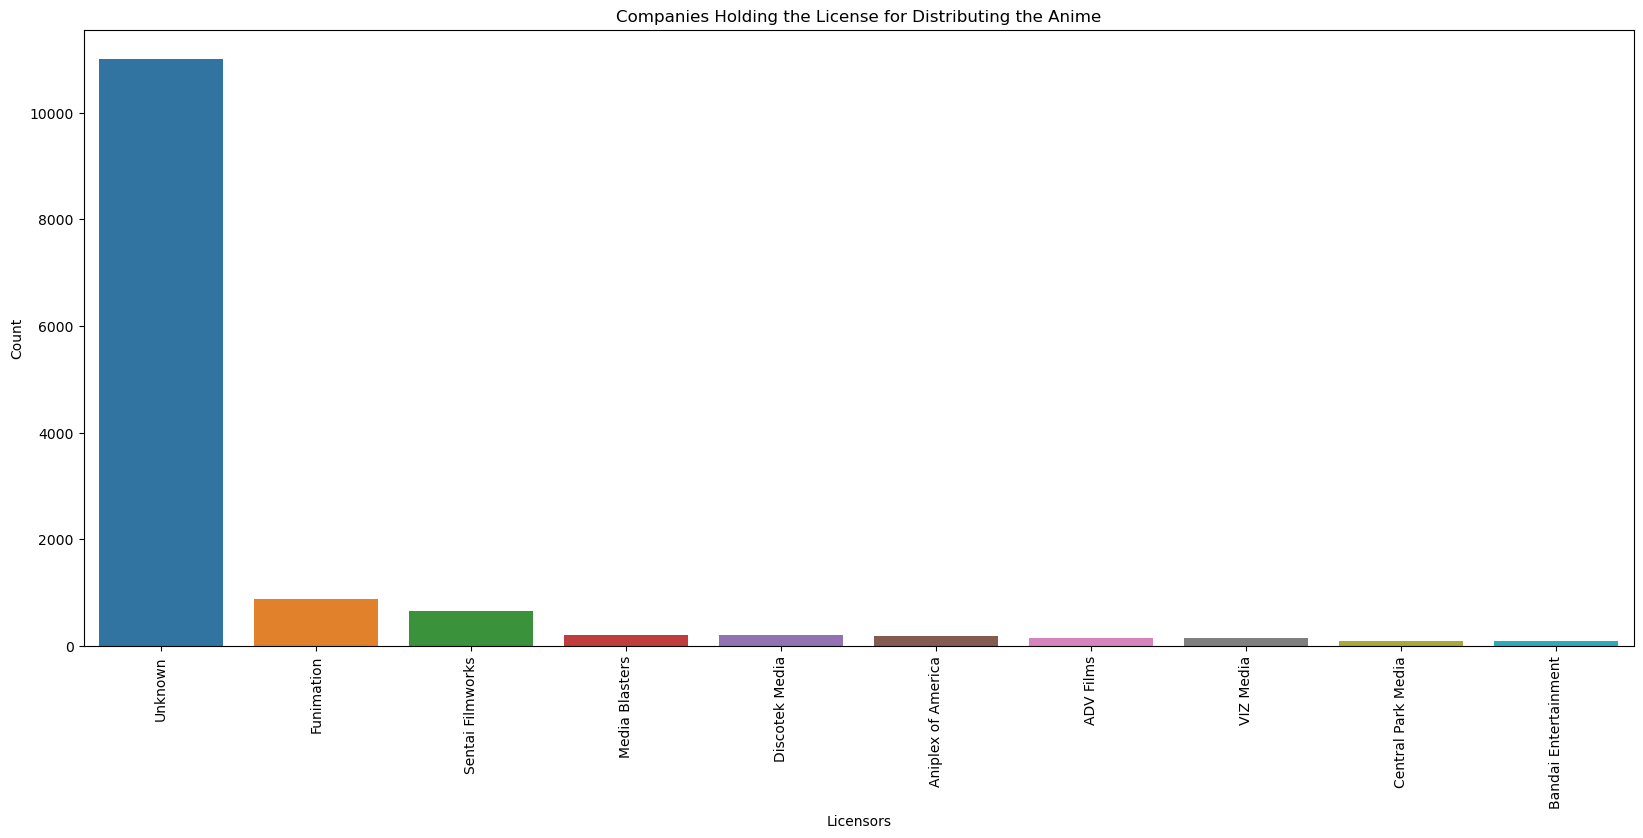

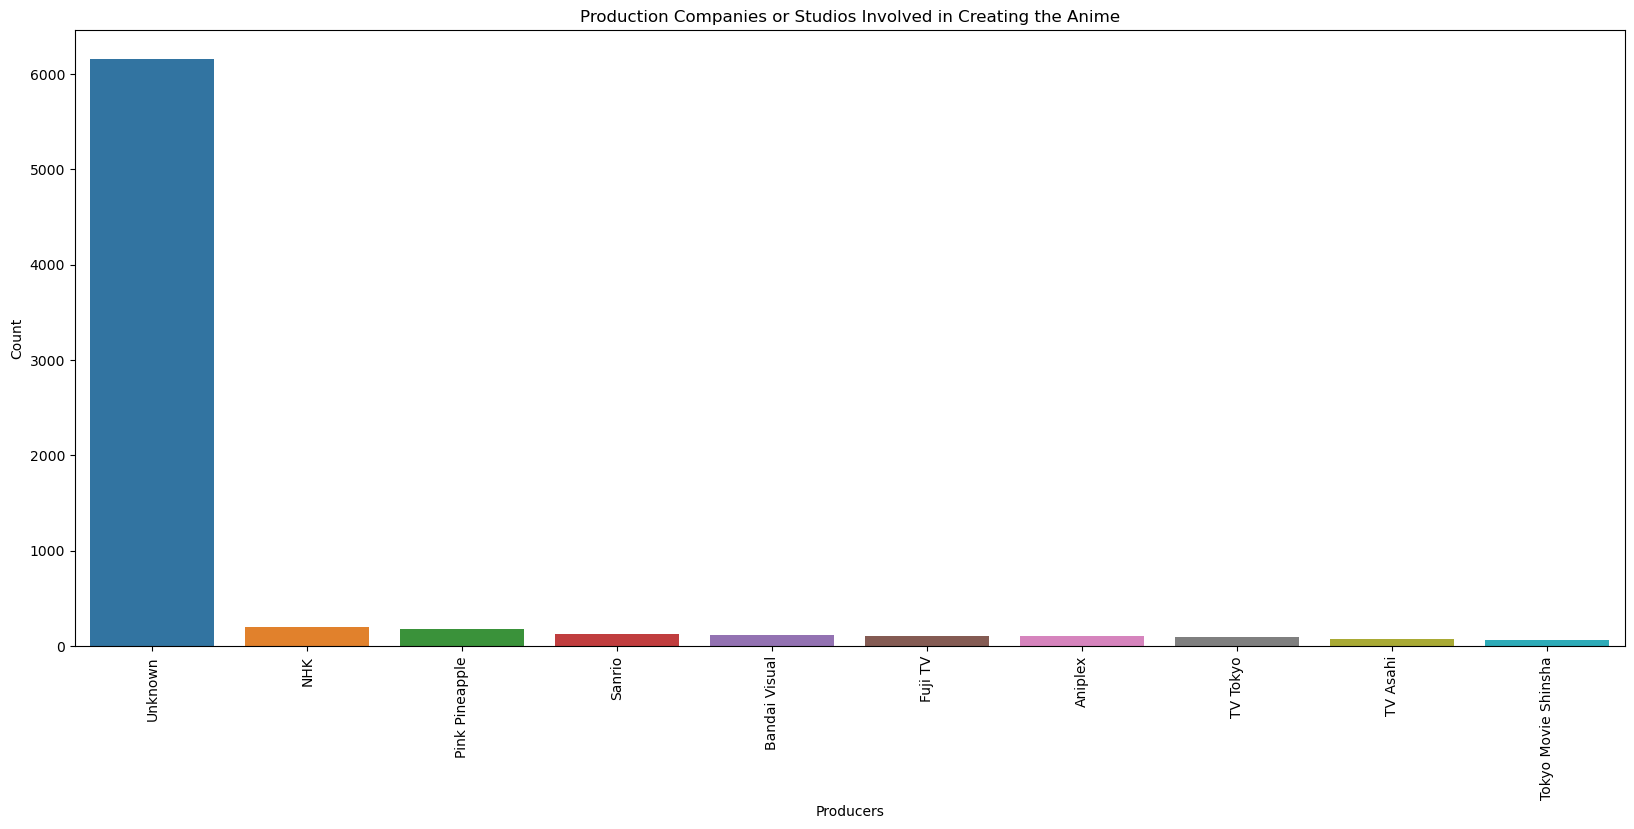

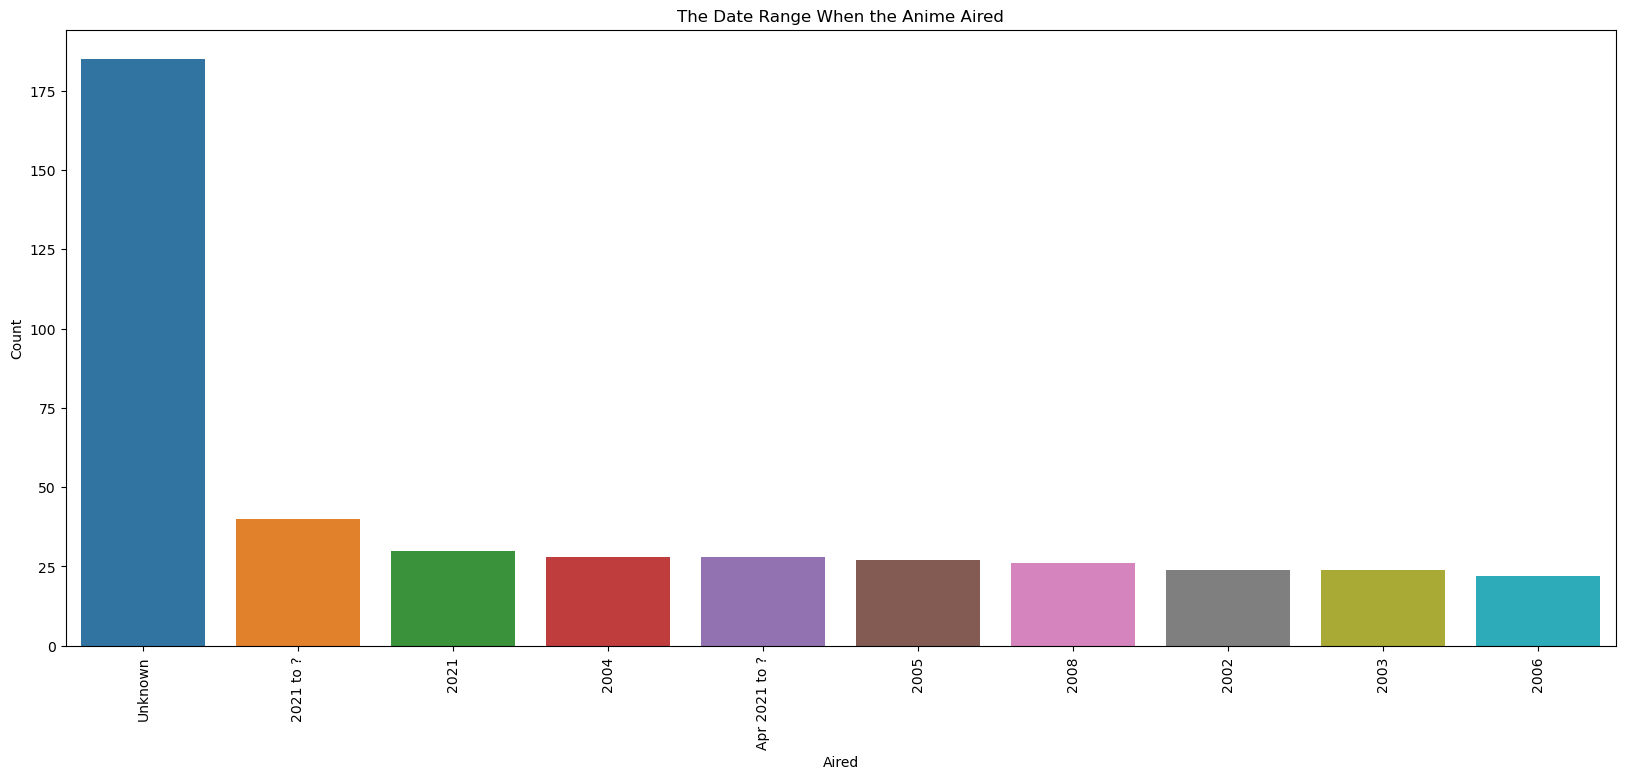

In [47]:
def plot_value_counts(df, column, num_items=10, plot_title="Value Counts", x_label="Category"):
    # Calculate value counts
    result = df.groupBy(column).count().orderBy(desc("count")).limit(num_items).toPandas()

    # Plotting the results
    plt.figure(figsize=(20, 8))
    sns.barplot(x=column, y="count", data=result)
    plt.title(plot_title)
    plt.xlabel(x_label)
    plt.ylabel('Count')
    plt.xticks(rotation=90)
    plt.show()

# Usage Examples
plot_value_counts(anime, "Type", 7, "Distribution of Anime Types", "Types of Broadcast Method")
plot_value_counts(anime, "Studios", 40, "Types of Studios Producing Anime", "Studios")
plot_value_counts(anime, "Source", 40, "Source Material for the Anime", "Source Material")
plot_value_counts(anime, "Duration", 10, "The Duration of Each Episode", "Duration")
plot_value_counts(anime, "Rating", 40, "The Target Audience Rating for the Anime", "Rating")
plot_value_counts(anime, "Genres", 40, "The Genres of the Anime", "Genres")
plot_value_counts(anime, "Licensors", 10, "Companies Holding the License for Distributing the Anime", "Licensors")
plot_value_counts(anime, "Producers", 10, "Production Companies or Studios Involved in Creating the Anime", "Producers")
plot_value_counts(anime, "Aired", 10, "The Date Range When the Anime Aired", "Aired")


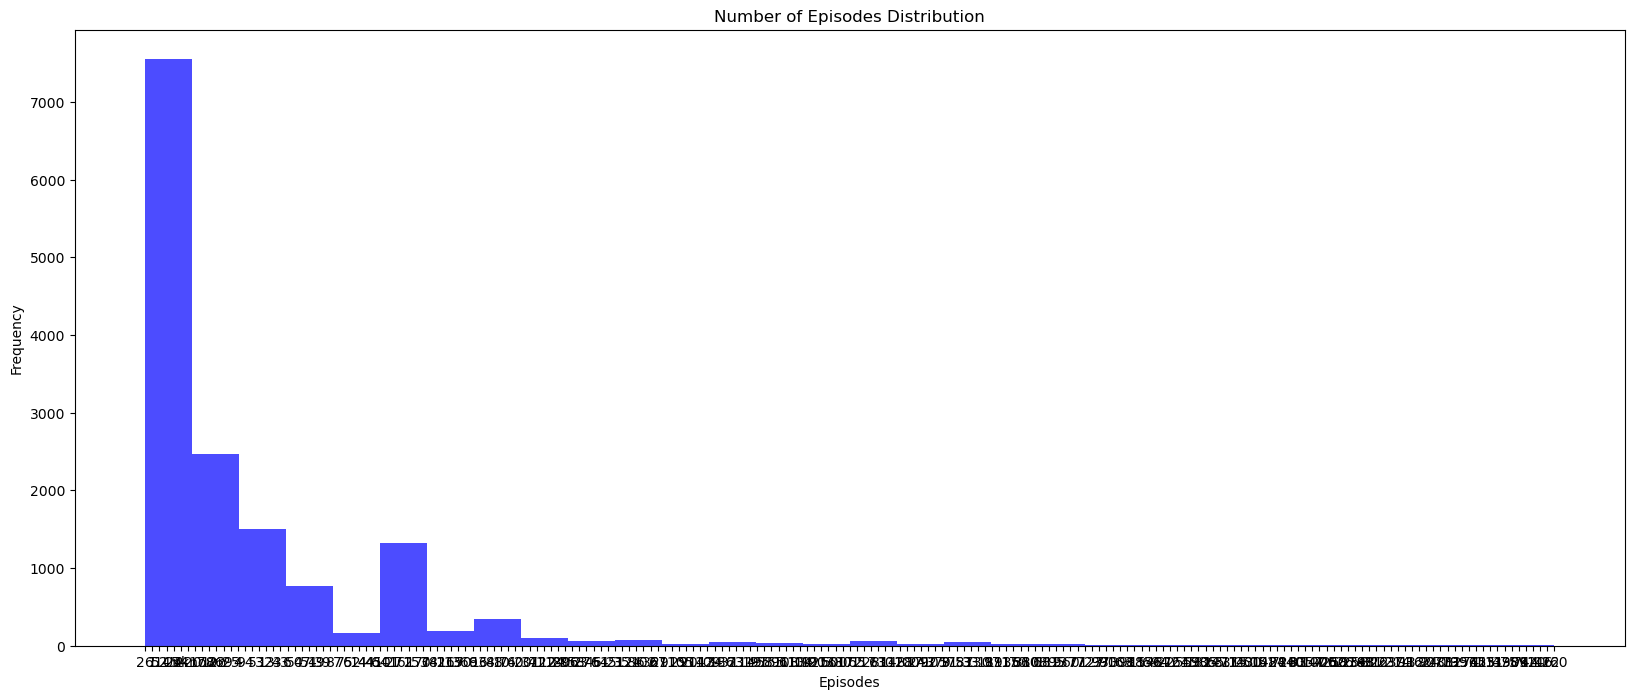

In [48]:
def plot_numeric_distribution(df, column, num_bins=30, plot_title="Numeric Distribution", x_label="Value"):
    # Collecting data
    data = df.select(column).rdd.flatMap(lambda x: x).collect()

    # Plotting the results
    plt.figure(figsize=(20, 8))
    plt.hist(data, bins=num_bins, color='blue', alpha=0.7)
    plt.title(plot_title)
    plt.xlabel(x_label)
    plt.ylabel('Frequency')
    plt.show()

# Usage Example
plot_numeric_distribution(anime, "Episodes", 30, "Number of Episodes Distribution", "Episodes")
